In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tf_agents
import gym
import gym_maze

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
import pygame
pygame.init()
pygame.display.list_modes()

[(1024, 768)]

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## Maze Environment

The maze environment implementation we will use is an open source custom OpenAI Gym environment called [Gym-Maze](https://github.com/MattChanTK/gym-maze).

> [Gym-Maze is a] simple 2D maze environment where an agent (blue dot) finds its way from the top left corner (blue square) to the goal at the bottom right corner (red square). The objective is to find the shortest path from the start to the goal. The agent may only choose to go up, down, right, or left ("N", "S", "E", "W"). If the way is blocked, it will remain at the same the location. The observation space is the (x, y) coordinate of the agent. The top left cell is (0, 0). A reward of 1 is given when the agent reaches the goal. For every step in the maze, the agent recieves a reward of -0.1/(number of cells).

In [5]:
from mlrl import make_maze_env
from mlrl import render_maze as render

In [6]:
env = make_maze_env()

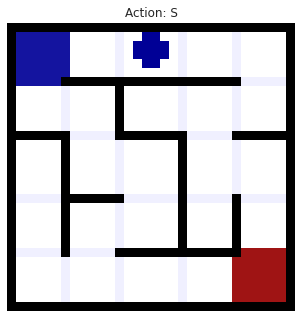

In [7]:
from IPython.display import clear_output
import time

try:
    env.reset()
    title = f'Action: None'
    while True:
        # render
        render(env, title=title)
        clear_output(wait=True)
        time.sleep(0.05)
        
        # act
        random_action = env.action_space.sample()
        title = f'Action: {env.ACTION[random_action]}'
        env.step(random_action)
        
except KeyboardInterrupt:
    pass

## Tracking and Setting States

In order to construct a search tree over the environment we need to be able to track and set the object-level states. Each node in a search tree will hold a state that we have explored, but we do not want to constantly copy the entire environment object as most of this will be irrelevant information. In order to perform a node expansion we will set the environment state to the state of the node, perform an action using `env.step`, and create a new child node from the resultant state of the environment.

The Gym-Maze environment tracks the state of the robot in the maze with the `env.state` and `env.maze_view._MazeView2D__robot` variables. But we also need to track the `env.steps_beyond_done` and `env.done` variables in order to prevent issues when we use `env.step`. When setting a state we follow the same procedure as `env.reset`, except with our target variables. This procedure can be seen [here in the Gym-Maze source code](https://github.com/MattChanTK/gym-maze/blob/83176811b49b5538a6213520612f44fb1bc49114/gym_maze/envs/maze_env.py#L92).

### Creating getters/setters

Reseting the environment and taking a random direction

In [14]:
env = make_maze_env(maze_size=(10, 10), seed=42)

In [15]:
move_right_action = 2
env.step(move_right_action)

(array([1, 0]), -0.001, False, {})

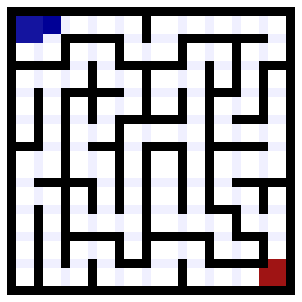

In [16]:
render(env)

Keep note of this state, as it is what we will aim to restore

Defining the state getters and setters

In [16]:
def get_state(env):
    return (np.array(env.state.copy()), env.steps_beyond_done, env.done)


def set_state(env, state):    
    robot_state, steps_beyond_done, done = state 
    
    env.maze_view._MazeView2D__draw_robot(transparency=0)
    env.maze_view._MazeView2D__robot = robot_state
    env.maze_view._MazeView2D__draw_robot(transparency=255)
    
    env.state = robot_state
    env.steps_beyond_done = steps_beyond_done
    env.done = done

Storing the current state to show the getter work

In [18]:
state = get_state(env)
state

(array([1, 0]), None, False)

Taking another few steps to the right.

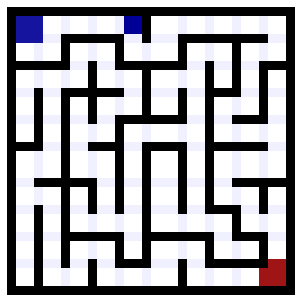

In [19]:
for _ in range(3):
    env.step(move_right_action)
render(env)

Seeing that the `set_state` function correctly restores the original state before the second step.

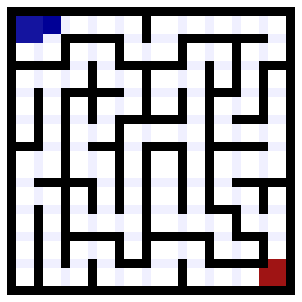

In [20]:
set_state(env, state)
render(env)

Move down from the restored state to confirm that the state was properly reconfigured.

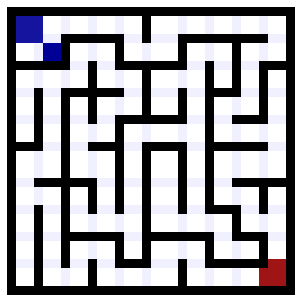

In [21]:
move_down_action = 1
env.step(move_down_action)
render(env)

## Search Tree Representation

In [7]:
from mlrl import MazeState, SearchTree, SearchTreeNode

In [8]:
env = make_maze_env()

search_tree = SearchTree(env, MazeState.extract_state)
search_tree

action=None, reward=0, state=(0, 0), children=defaultdict(<class 'list'>, {})

In [13]:
import random
random.seed(0)

N = 50
for i in range(N):
    node = random.choice(list(range(len(search_tree.get_nodes()))))
    action = random.randint(0, env.action_space.n - 1)
    if N <= 10:
        print(f'Expanding {search_tree.get_nodes()[node].state} with action {env.ACTION[action]}')
    search_tree.expand(node, action)

In [9]:
from networkx.drawing.nx_pydot import graphviz_layout
from mlrl.utils import hierarchy_pos_large_tree
import networkx as nx


def construct_tree(tree: nx.DiGraph, node: SearchTreeNode):
    tree.add_node(hash(node), state=str(node.state))
    for action, children in node.get_children().items():
        for child in children:
            construct_tree(tree, child)
            tree.add_edge(hash(node), hash(child), 
                action=env.ACTION[action], 
                reward=child.get_reward_received())


def show_tree(search_tree: SearchTree, figsize=(20, 20), show_reward=False):

    nx_tree = nx.DiGraph()
    construct_tree(nx_tree, search_tree.get_root())

    pos = hierarchy_pos_large_tree(nx_tree, hash(search_tree.get_root()), width=250, height=250)
    edge_labels = {
        (n1, n2): '{} ({:.2f})'.format(data['action'], data['reward']) if show_reward else data['action']
        for n1, n2, data in nx_tree.edges(data=True)
    }
    node_labels = {
        node: nx_tree.nodes.get(node)['state'] for node in nx_tree.nodes()
    }

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()

    nx.draw(nx_tree, pos, node_size=1800, ax=ax)

    nx.draw_networkx_edge_labels(nx_tree, pos, edge_labels=edge_labels, ax=ax)
    nx.draw_networkx_labels(nx_tree, pos, labels=node_labels, ax=ax, font_color='white')
    plt.axis('off')
    axis = plt.gca()
    zoom = 10
    axis.set_xlim([axis.get_xlim()[0] - zoom, axis.get_xlim()[1] + zoom])
    axis.set_ylim([axis.get_ylim()[0] - zoom, axis.get_ylim()[1] + zoom])
    # plt.tight_layout()
    plt.show()

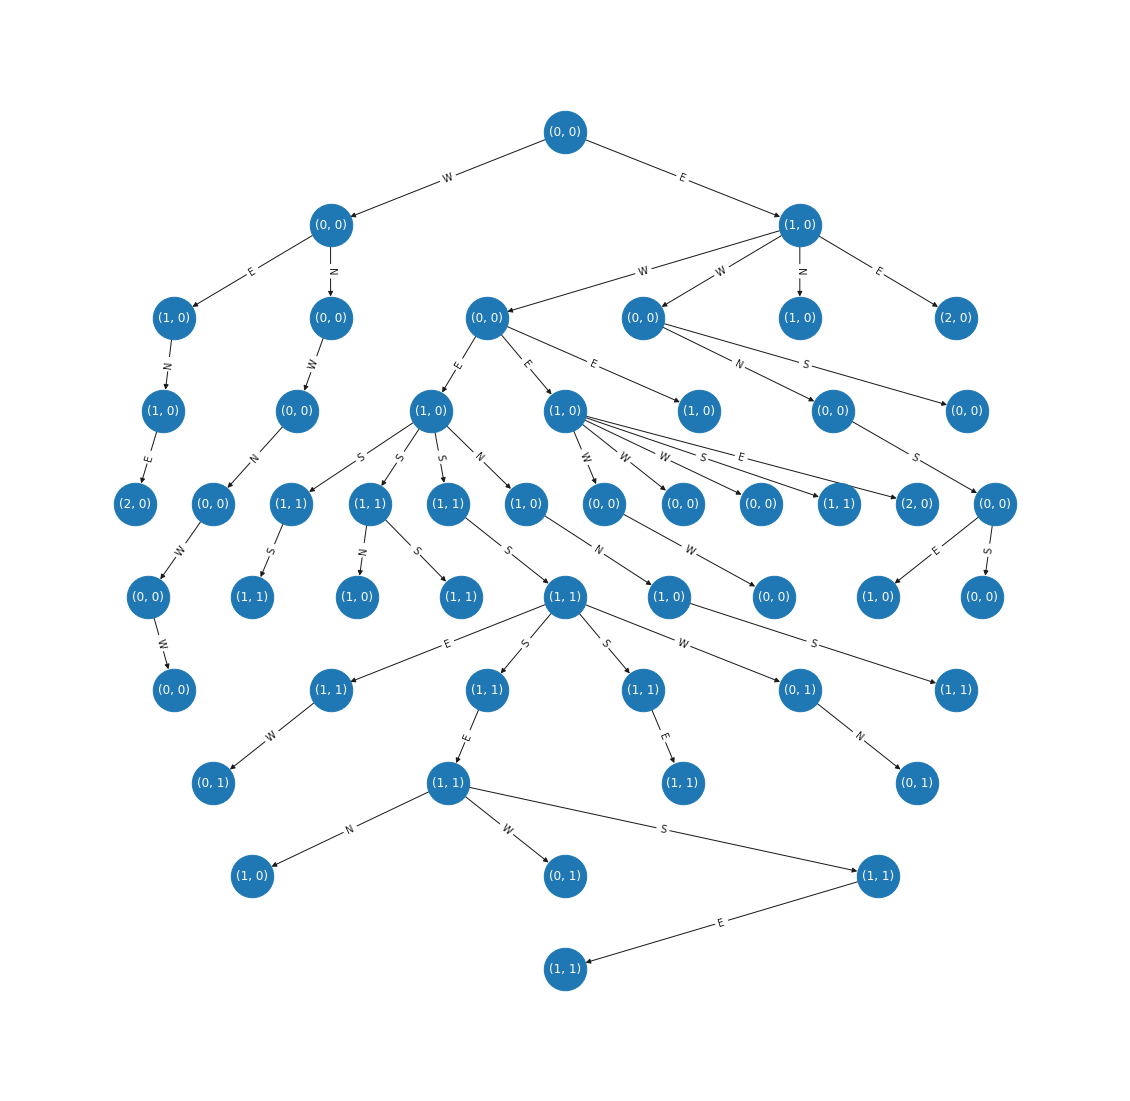

In [15]:
show_tree(search_tree)

## Search-Amplified Object-level Q-Value Estimation

In [10]:
from mlrl.search_tree import ObjectState

from abc import ABC, abstractmethod


class QFunction(ABC):
    
    @abstractmethod
    def compute_q(self, state: ObjectState, action: int) -> float:
        pass
    
    def __call__(self, state: ObjectState, action: int) -> float:
        return self.compute_q(state, action)


class SimpleSearchBasedQEstimator:
    """
        Assumes a deterministic environment and only uses child nodes to compute Q-values
    """
    
    def __init__(self, q_hat: QFunction, search_tree: SearchTree,
                 n_actions: int = 4, 
                 discount: float = 0.99):
        self.n_actions = n_actions
        self.discount = discount
        self.q_hat = q_hat
        self.search_tree = search_tree
    
    def compute_q(self, search_tree_node: SearchTreeNode, action: int) -> float:
        """ 
        Computes the Q-value for a given state and action using the search 
        tree and the Q-hat function to evaluate the leaf nodes.
        
        Args:
            search_tree_node: The node in the search tree corresponding to the state
            action: The action to evaluate
        """
        children = search_tree_node.get_children()
        if action in children:
            child_node = children[action][0] 
            reward = child_node.get_reward_received()
            return reward + self.discount * self.compute_value(child_node)
        
        return self.q_hat(search_tree_node.get_state(), action)
    
    def compute_value(self, search_tree_node: SearchTreeNode) -> float:
        return max(self.compute_q(search_tree_node, action) for action in range(self.n_actions))

In [11]:
import re
from mlrl.maze_state import MazeState
# from mlrl.search_tree import QFunction
import numpy as np

from typing import Tuple


class ManhattanQHat(QFunction):
    
    def __init__(self, env: 'MazeEnv', discount: float = 0.99):
        self.env = env
        self.goal_state = env.maze_view.goal
        self.discount = discount

        # see source code of gym_maze.envs.maze_env.MazeEnv for hard-coded reward values
        # https://github.com/MattChanTK/gym-maze/blob/master/gym_maze/envs/maze_env.py
        self.goal_reward = 1
        self.step_reward = -0.1/(env.maze_size[0]*env.maze_size[1])

    def get_next_position(self, state: MazeState, action: int) -> np.array:
        """
        Uses the environment to simulate taking the action and return the next state position
        """
        state.set_environment_to_state(self.env)
        elapsed_steps = env._elapsed_steps
        next_state, *_ = self.env.step(action)
        # ensure that this doesn't count towards time limit in the environment
        env._elapsed_steps = elapsed_steps 
        return next_state
        
    def compute_q(self, state: MazeState, action: int) -> float:
        state_pos = state.get_state_vector()
        if np.array_equal(state_pos, self.goal_state):
            return 0
        
        next_state_pos = self.get_next_position(state, action)
        dist = np.abs(next_state_pos - self.goal_state).sum()

        if dist == 0:
            return self.goal_reward

        exp_goal_reward = self.goal_reward * self.discount ** dist
        exp_cost_to_goal = self.step_reward * dist * (1 - self.discount**dist) / (1 - self.discount)
        return exp_goal_reward + exp_cost_to_goal

In [54]:
q_hat = ManhattanQHat(env)
q_est = SimpleSearchBasedQEstimator(q_hat, search_tree)

In [55]:
q_est.compute_value(search_tree.get_root())

0.8280360437209697

In [12]:
def create_maze_state(pos: np.array, env: 'MazeEnv') -> MazeState:
    gym_state = (pos, 0, np.array_equal(pos, env.maze_view.goal), env._elapsed_steps)
    return MazeState(pos, gym_state)

In [13]:
def visualise_q_hat(q_hat: QFunction, env: 'MazeEnv'):

    maze_w, maze_h = env.maze_size
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for action, ax in enumerate(axs):
        q_vals = np.array([[
                q_hat(create_maze_state(np.array([x, y]), env), action)
                for x in range(maze_w)
            ] for y in range(maze_h)
        ])
        q_vals[env.maze_view.goal[1], env.maze_view.goal[0]] = 0
        
        ax.set_title(f'Action: {env.ACTION[action]}')
        sns.heatmap(q_vals, annot=True, square=maze_w==maze_h, fmt='.2f', cbar=False, ax=ax, vmin=0, vmax=1);
        ax.axis('off')
    
    plt.show()
    render(env)

In [14]:
def visualise_manhattan_q_hat(env: 'MazeEnv'):
    q_hat = ManhattanQHat(env)
    visualise_q_hat(q_hat, env)

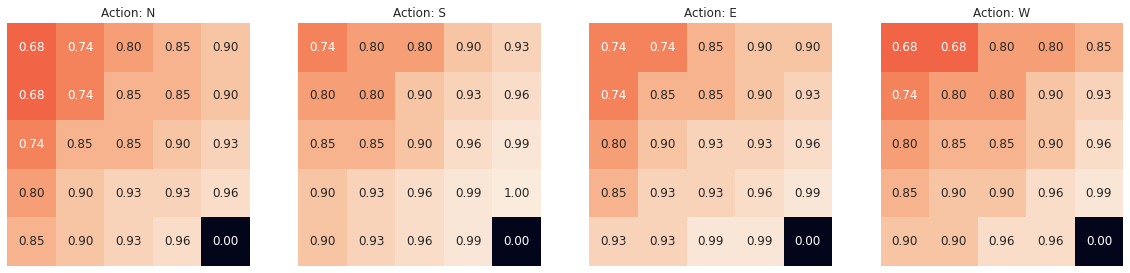

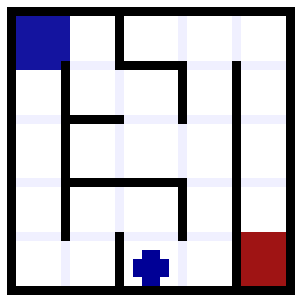

In [59]:
env = make_maze_env((5, 5))
visualise_manhattan_q_hat(env)

In [15]:
def create_depth_n_tree(env: 'MazeEnv', start_pos: np.array, n: int = 2) -> SearchTree:
    root_state = create_maze_state(start_pos, env)
    root_state.set_environment_to_state(env)
    search_tree = SearchTree(env, extract_state=MazeState.extract_state)
    to_expand = [0]
    for _ in range(n):
        new_to_expand = []
        for node_idx in to_expand:
            for action in range(env.action_space.n):
                success = search_tree.expand(node_idx, action)
                if success:
                    new_node_idx = len(search_tree.node_list) - 1
                    new_to_expand.append(new_node_idx)
        to_expand = new_to_expand

    return search_tree

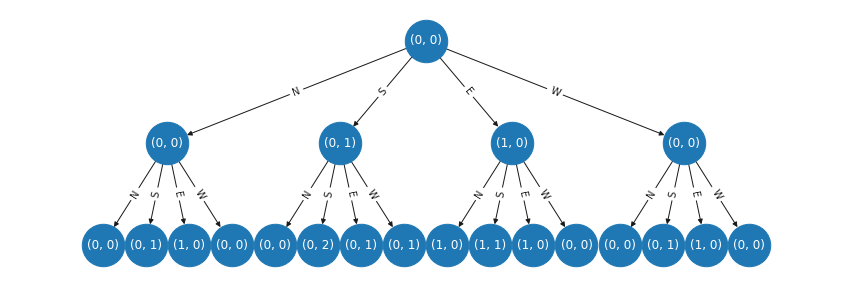

In [61]:
env = make_maze_env()
tree = create_depth_n_tree(env, np.array([0, 0]), 2)
show_tree(tree, figsize=(15, 5))

In [16]:
class DepthNSearchQFn(QFunction):
    
    def __init__(self, env: 'MazeEnv', n: int = 2):
        self.env = env
        self.q_hat = ManhattanQHat(env)
        self.n = n
        
    def compute_q(self, state: MazeState, action: int) -> float:
        state_pos = state.get_state_vector()
        search_tree = create_depth_n_tree(self.env, state_pos, self.n)
        q_est = SimpleSearchBasedQEstimator(self.q_hat, search_tree)
        return q_est.compute_q(search_tree.get_root(), action)

In [17]:
def visualise_depth_n_q_hat(env: 'MazeEnv', n: int = 2):
    q_hat = DepthNSearchQFn(env, n=n)
    visualise_q_hat(q_hat, env)

In [18]:
env = make_maze_env()

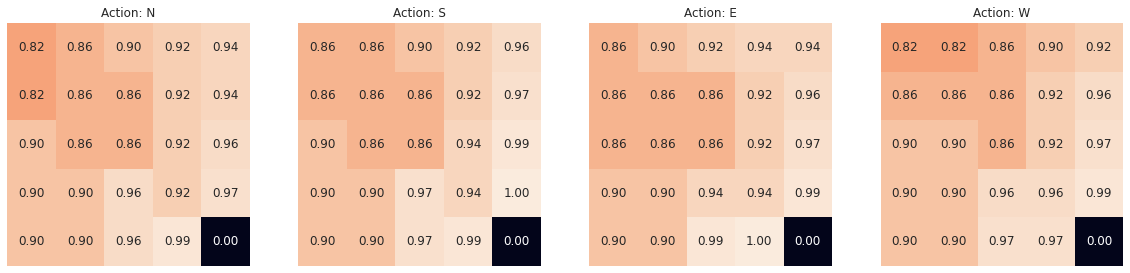

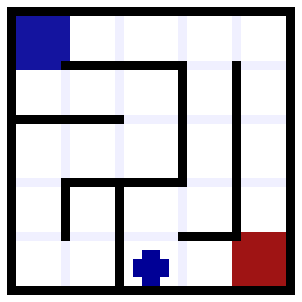

In [66]:
visualise_depth_n_q_hat(env, 3)

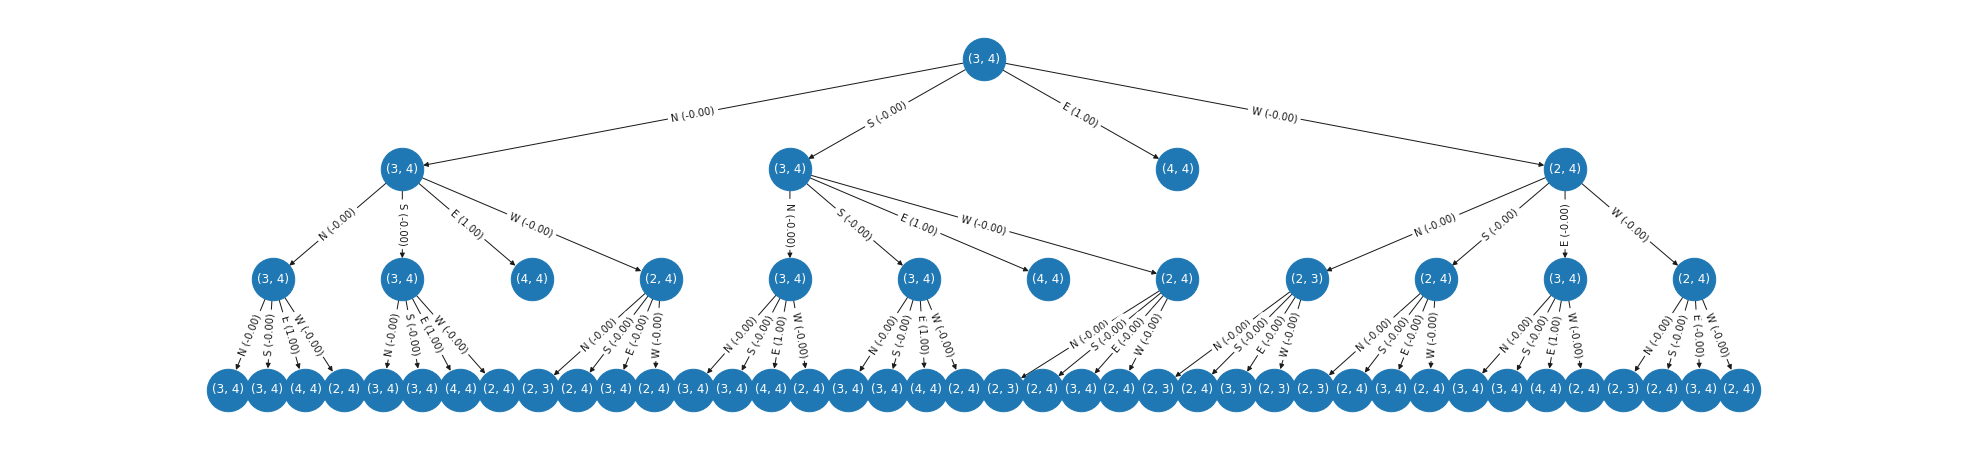

In [75]:
pos = env.maze_view.goal - np.array([1, 0])
show_tree(create_depth_n_tree(env, pos, 3), 
          figsize=(35, 8), show_reward=True)

## Creating the Meta Environment

In [19]:
from typing import Callable

import gym


class MetaEnv(gym.Env):
    """
    Class that wraps a gym_maze environment and allows for the meta-learning of the search problem
    """

    def __init__(self, 
                 env: gym.Env, 
                 q_hat: QFunction,
                 make_tree: Callable[[gym.Env], SearchTree],
                 object_state_vec_size: int = 2,
                 max_tree_size: int = 10):
        self.env = env
        self.q_hat = q_hat
        self.max_tree_size = max_tree_size
        self.action_space = gym.spaces.Discrete(1 + max_tree_size * env.action_space.n)
        self.n_meta_data = 3 # number of meta data features: parent node idx, action, reward
        self.observation_space = gym.spaces.Box(
            low=0, high=max_tree_size, 
            shape=(max_tree_size, self.n_meta_data + object_state_vec_size), 
            dtype=np.float32
        )

        self.make_tree = make_tree
        self.tree = None
        self.n_computations = 0

    def reset(self):
        self.env.reset()
        self.tree = self.get_root_tree()
        self.n_computations = 0

    def get_root_tree(self) -> SearchTree:
        """ Creates a new tree with the root node set to the current state of the environment """
        return self.make_tree(self.env)

    def tokenise_node(self, node: SearchTreeNode) -> np.array:
        meta_features = np.array([node.get_parent_id(), node.get_action(), node.reward], dtype=np.float32)
        return np.concatenate([meta_features, node.state.get_state_vector()])

    def get_observation(self) -> np.array:
        obs = np.array([
            self.tokenise_node(node)
            for node in self.tree.node_list
        ])
        padding = np.zeros((self.max_tree_size - obs.shape[0], obs.shape[1]))
        return np.concatenate([obs, padding])

    def get_object_action(self) -> int:
        q_est = SimpleSearchBasedQEstimator(self.q_hat, self.tree)
        return max(range(self.env.action_space.n), 
                   key=lambda a: q_est.compute_q(self.tree.get_root(), a))
    
    def step(self, action: int):
        if action == 0 or self.tree.get_num_nodes() >= self.max_tree_size:
            root_state = self.tree.get_root().get_state()
            root_state.set_environment_to_state(self.env)
            _, reward, done, info = self.env.step(self.get_object_action())
            self.tree = self.get_root_tree()
            return self.get_observation(), reward, done, info

        computation_action = (action - 1) // 4
        object_action = (action - 1) % 4

        reward = 0
        self.tree.expand(computation_action, object_action)
        self.n_computations += 1

        return self.get_observation(), reward, False, dict()

### Showing It Working

In [76]:
env = make_maze_env(seed=0)
q_hat = ManhattanQHat(env)

def make_maze_search_tree(env: 'MazeEnv') -> SearchTree:
    return SearchTree(env, extract_state=MazeState.extract_state)

meta_env = MetaEnv(env, q_hat, make_maze_search_tree)

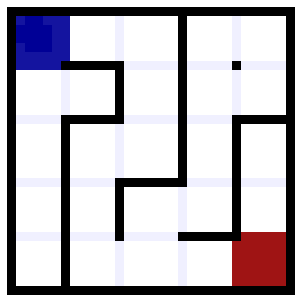

In [78]:
env.reset()
render(env)

In [79]:
meta_env.reset()

In [80]:
meta_env.get_observation()

array([[-1., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [81]:
expand_node = 0
object_action = env.ACTION.index('S')
meta_action = 1 + 4 * expand_node + object_action
meta_env.step(meta_action)

(array([[-1.   , -1.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.   , -0.004,  0.   ,  1.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]),
 0,
 False,
 {})

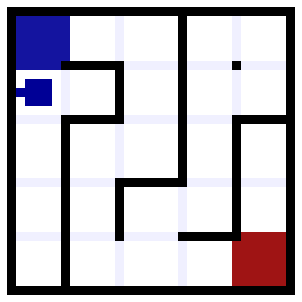

In [82]:
render(env)

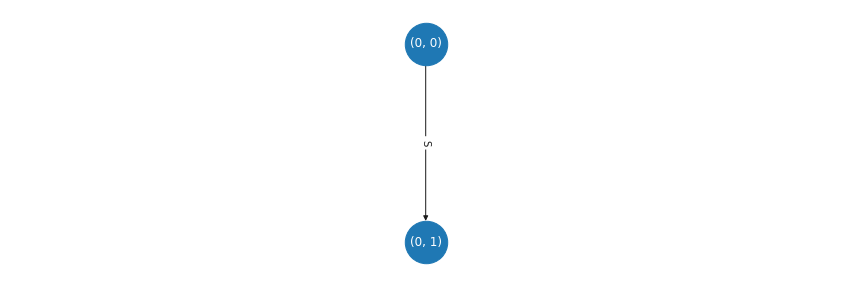

In [83]:
show_tree(meta_env.tree, figsize=(15, 5))

In [84]:
expand_node = 0
object_action = env.ACTION.index('E')
meta_action = 1 + 4 * expand_node + object_action
meta_env.step(meta_action)

(array([[-1.   , -1.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.   , -0.004,  0.   ,  1.   ],
        [ 0.   ,  2.   , -0.004,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]),
 0,
 False,
 {})

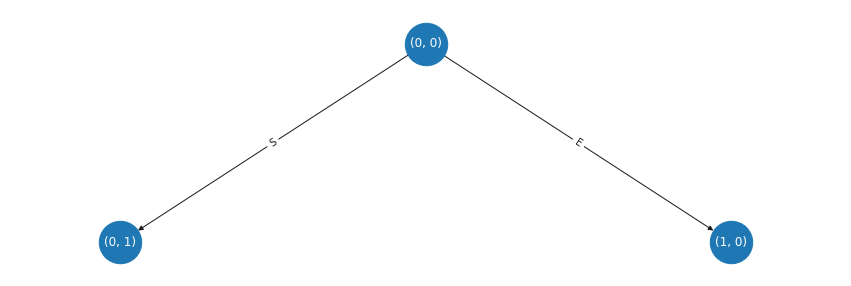

In [85]:
show_tree(meta_env.tree, figsize=(15, 5))

In [86]:
expand_node = 2
object_action = env.ACTION.index('E')
meta_action = 1 + 4 * expand_node + object_action
meta_env.step(meta_action)

(array([[-1.   , -1.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.   , -0.004,  0.   ,  1.   ],
        [ 0.   ,  2.   , -0.004,  1.   ,  0.   ],
        [ 2.   ,  2.   , -0.004,  2.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]),
 0,
 False,
 {})

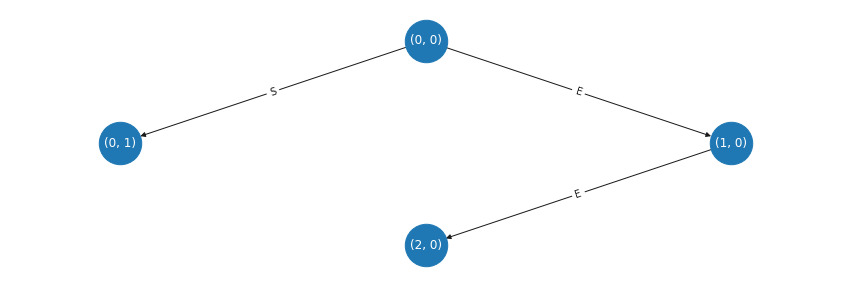

In [87]:
show_tree(meta_env.tree, figsize=(15, 5))

In [88]:
meta_action = 0  # take object action (terminate computation)
meta_env.step(meta_action)

(array([[-1., -1.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]),
 -0.004,
 False,
 {})

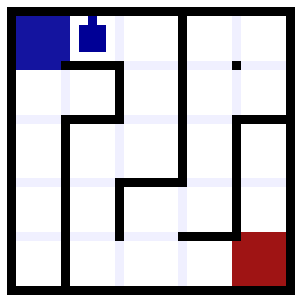

In [89]:
render(env)